# text2poem

### Aim
Given a textual description, generate a poem from it. 

### To-Do
- [ ] Clean up the variable names, etc
- [ ] Understand the T5 architecture and freeze the base layers if needed
- [ ] Create the $(\text{summary}, \ \text{poem})$ dataset using sites like [Poem Analysis](https://poemanalysis.com/). Ideally, smaller poems would be preffered. Might need to create manually, as scraping is not only difficult, but also lead to bad data. Stanza-by-Stanza is too detailed, and some summaries barely contain any information about the poem. Thus, data samples may need to be manually checked. Need to select famous poems that have good quality summaries available.
    - Doesn't work properly when tested with training set of $9$ poems, will need to try with more data
    - Another alternative, $(\text{topic}, \ \text{poem})$ dataset. Given a set of keywords, generate a poem. Dataset creation would be simple using LDA topic modelling etc.
        - [Topic Idenitification NLP 1](https://www.pluralsight.com/guides/topic-identification-nlp)
        - [Topic Idenitification NLP 2](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)
        - [Example](https://monkeylearn.com/keyword-extractor-online/)
- [ ] Clean the dataset, remove very long poems, if possible select by prominent authors, remove poems with no rhyming scheme.
- [ ] Change the RAKE algorithm
    - Maybe try using POS tagging in some way
- [ ] Check whether tokenizer preserves "\n" else replace by some other token
    - It's based on SentencePiece which doesn't preserve "\n"
- [ ] Calculate lengths of poems after data cleaning
### Ideas
- [ ] Rhyming scheme as T5 prefix

### References
- [Base code for this notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) (This had quite a few bugs) 
- [T5 finetuning tips](https://discuss.huggingface.co/t/t5-finetuning-tips/684/2)
- [T5 Docs](https://huggingface.co/transformers/model_doc/t5.html)
- [Training T5](https://huggingface.co/transformers/model_doc/t5.html#training) (Not detailed enough)
- [Finetuning T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) (Probably the most extensive tutorial)
- [Few Shot Learning with T5](https://towardsdatascience.com/poor-mans-gpt-3-few-shot-text-generation-with-t5-transformer-51f1b01f843e)
- [Some Famous Poetry](https://medium.com/@EmEmbarty/31-of-the-best-and-most-famous-short-classic-poems-of-all-time-e445986e6df)
- [Poetry Summaries](https://www.litcharts.com/poetry/)
- [A great blog on how to generate text](https://huggingface.co/blog/how-to-generate)


## Install Dependencies

In [1]:
# Transformer changes very frequently, thus the version is important
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 9.0MB/s 
     |████████████████████████████████| 3.3MB 41.0MB/s 
     |████████████████████████████████| 901kB 39.7MB/s 
     |████████████████████████████████| 1.1MB 10.7MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [3]:
%reset -f

## Import Libraries

In [4]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# The T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla K80


## Constants

In [6]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics_improved_bigrams_150.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 256
SUMMARY_LEN = 256

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 5 # 5 is good enough for 5k samples in data
LR = 3e-4

In [7]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [8]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [9]:
def replaceSep(text, sep = " | "):
    if type(text) == float:
        print(text)
    return text.replace("\n", sep)

In [10]:
def loadDF(path, n_rows = None, split = 0.9,  prefix = "summarize: "):
    """ Loads the CSV data and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")
    df.dropna(inplace = True)
    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]
    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)
    # Add a suitable prefix to the text input
    df.input = prefix + df.input
    # Truncate the dataset if required
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    df["input"] = df["input"].apply(replaceSep)
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, train_size = split, random_state = SEED, shuffle = True)
    
    if len(df_val) > 5:
        df_val = df_val[:5]

    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [11]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [12]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

In [13]:
# ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
# ds_train[0] # For quickly testing the data format

In [14]:
# temp = tokenizer(
#     ["hello\nmy friend* how| are|you today*haha"],
#     # max_length = self.inp_len, 
#     #padding = "max_length", 
#     #truncation = True,
#     return_tensors = "pt"
# ).input_ids
# ok = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in temp]
# print(ok)

## Train and Validate Functions:

In [15]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [16]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [17]:
def generate(topics):

    input = "poetify: " + " | ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [36]:
def genSample(topics, min_length, max_length, rep_penalty):

    input = "poetify: " + " | ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        # temperature=0.7,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [19]:
# gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"])

## Main

In [20]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [21]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = "poemify: ")
print(len(df), len(df_train), len(df_val))

7257 6531 5


In [22]:
display(df)

,output,input
0,A barefoot boy! I mark him at his play— | For ...,poemify: feverish stripes | dusty trousers | o...
1,The warping night air having brought the boom ...,poemify: s voice | odd question | forest bird ...
2,Habits accrue | in circular pattern | and livi...,poemify: circular pattern | chord progressions...
3,“A Billion Things in One” is an erasure of the...,poemify: erasure | Times | June | York | Berli...
4,"A Bird, came down the Walk - | He did not know...",poemify: frightened Beads | softer Home | rapi...
...,...,...
7269,my father’s body is a map | a record of his jo...,poemify: left thigh | own opinions | nose fath...
7270,this morning | weaving Chi in the garden | inv...,poemify: solid bones | limber pine | * scent |...
7271,walking up John Street | thinking of you | | ...,poemify: thinking | matter | John | Street | l...
7272,"carnegie hall, october 19, 2014 | beauty elude...",poemify: dissonant root | flush vivid | i conj...


In [23]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

3266 3


### Loading the Model

In [24]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [25]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [26]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [27]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))



Epoch 1



Epoch 2



Epoch 3



Epoch 4


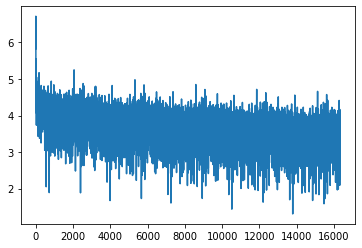

In [28]:
plt.plot(range(len(losses)), losses)
plt.show()

In [29]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [30]:
display(results)

,Generated Text,Actual Text
0,I am the first animal | to be taken back. It i...,I put an animal on an animal | which I put ont...
1,"The first fire is a new world, | the undevelop...",the unthinkable prospect | of a world in which...
2,I can’t remember the language | of embroidered...,"The dryer, uniform and squat as a biscuit tin,..."
3,"The slumber of the moon, | and all other eyes....",When on the marge of evening the last blue lig...
4,Past is the central point of fact. | The pipe ...,Tune yr sandwich to the key of C | Make biscui...


In [33]:
x = 4
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

Past is the central point of fact. | The pipe gathers lead from a door to open, and it’ll be innocent! 

Tune yr sandwich to the key of C | Make biscuits in kitchen B | | Miss Scarlet with her lead pipe | Waits behind the cupboard door | | Clubs one from the other limp | Only to begin again innocent | | &amp; nothing to do but gather into | Legion gather into constellation | | Coming along then a spider its web | Holds the walls together holds the floor | | Up gathers toward a central point | Mean &amp; distribution derivation | | To insert a thumb &amp; see what sticks | Past the earth’s crust cirrus | | And acidic enough to spoon fork but | Chew &amp; eat &amp; swallow digesting the fact | | That nine wonders hope the clouds have | Answers hope the clouds have


In [39]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.2)

The rustling forest is desolate to the wind.
The tree is being weeping when winds enter us,
and even though they are still doing well it’s so;
Even as I have thought that there was no sun here,
I am deplorable for the thing like this.
By now I must be dehydrated into the river;
And because of that I cannot die then I will speak.
And my brother loves with the night!


In [43]:
gen = genSample(["happy", "elated smile", "good luck", "persian rugs", "beautiful eyes"], 100, 500, 1.2)

A well is not even a way to be
made of persian and rugs.
It's not so pleasant in sight,
but as I know it, no more;
And once I love you
I see your beauties!
But there's good luck in me
As this is the universe.
You need an elated smile
In the heart of happy eyes.
There are two gorgeous eyes (and one looks like a moon)
This is how they come.


In [45]:
gen = genSample(["syrupy sweet", "glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.2)

Is a joyous feeling for others
How could it be, of this glowing sun?
What is its syrupy sweet and our smile in the sky?
The happy faces of dancing trees have grown so smooth.
The moon grows thick with lightning. It stands like you'll see,
And the stars grow out all at once,
And the birds are flying as well.
The poets pass past them through my heart to swell together,
That I feel as if we had been waiting,
Shivering from their brow—
Only the happy faces of me know when they come.


In [53]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.1)

Let’s make no more joyful faces, though
God will help it sing, even if God
Or the elated smile of dancing trees.
For when God loves the glowing sun,
All the bright faces of the spirit’s curse
O Lord, who will bless me?
Where will you go, and where will you go?
If I shall be your father or I might be,
My son to thwart my self,
My son to die in his death?

He will speak again. And when the moon is gone,
When the wind came too;
Who could have found them
Through what I call joyous as he’s on her feet!
It’s the best for me like this,
And I will speak but once was with him.


In [56]:
df_val["input"][0]

'poemify: hoary sky | first animal | consistent light | long time | taking | silly | back | animals | tired'

In [66]:
gen = genSample(["hoary sky", "first animal", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.2)

The first animal in the country
takes a proper and consistent light.
And it’s not even too tired to go back
into the hoary sky.
It’s a long time since we had seen
animals in another town,
that made us live.
It doesn’t always happen here,
but you have no name
at all. So I know how silly it is—I am
the only one who does this again.
That’s like a child taking off-wheel
on the side of the world.


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```